In [31]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.metrics import BinaryCrossentropy  # Use TensorFlow's metrics module
import os
import PIL
import time
from IPython import display

In [ ]:
# Define the path to your dataset
root_path = "images"
data = pathlib.Path(dataset_path)

In [33]:
# Prepare the Data & View some samples
# Preparing data
batch_size = 32
# Use pathlib for compatibility and consistency
data_directory = pathlib.Path(root_path)
# Load images from the directory
data = keras.utils.image_dataset_from_directory( directory=data_directory,
label_mode=None, # No labels for GAN training
batch_size=batch_size,
image_size=(64, 64)
)

Found 63565 files.


In [34]:
data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

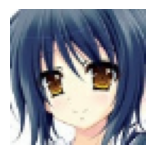

In [35]:
# Extract a batch of images from the dataset 
sample_images = next(iter(data))
# Plot the images
plt.figure(figsize=(6, 6))
for i in range(9): 
    ax = plt.subplot(3, 3, 1 + 1) 
    plt.imshow(sample_images[i].numpy().astype("uint8")) 
    plt.axis("off")

plt.show()

In [36]:
data = data.map(lambda d: (d - 127.5) / 127.5)
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [37]:
#Build the Generator function
def build_generator(latent_dim):
    generator = Sequential()

    generator.add(Dense(units=4*4*256, input_shape=(latent_dim,), use_bias=False)) 
    generator.add(Reshape((4, 4, 256))) 
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"))
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")) 
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")) 
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="tanh"))
    
    return generator
# Instantiate the generator model
latent_dim = 100
G_model=build_generator(latent_dim)
G_model.summary()
# optimizer
G_optm=Adam(1e-4)

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4096)           │       409,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,005,827 (3.84 MB)

 Trainable params: 1,004,547 (3.83 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [38]:
# Build the Discriminator
def build_discriminator():
    discriminator = Sequential()

    discriminator.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation=tf.nn.leaky_relu, input_shape=(64, 64, 3)))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation=tf.nn.leaky_relu))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same", activation=tf.nn.leaky_relu))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense (units=1, activation="sigmoid"))

    return discriminator
#Instantiate the discriminator model
D_model=build_discriminator()
D_model.summary()

# optimizer
D_optm=Adam(1e-4)

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,993 (1.48 MB)

 Trainable params: 388,097 (1.48 MB)

 Non-trainable params: 896 (3.50 KB)

In [39]:
#Define the GAN Model
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self. latent_dim = latent_dim
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        #Sample random points in the latent space
        batch_size = tf.shape(real_images) [0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self. latent_dim))
    
        #Generate fake images
        generated_images = self.generator(random_latent_vectors)
        
        #Combine real and fake images
        combined_images= tf.concat([generated_images, real_images], axis=0)
        
        #Create labels for the discriminator
        labels_discriminator=tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        
        #Add random noise to the labels (label smoothing)
        labels_discriminator += 0.05 * tf.random.uniform(tf.shape(labels_discriminator))
    
        #Train the discriminator
        with tf.GradientTape() as tape:
           predictions_discriminator = self.discriminator(combined_images)
           d_loss = self.loss_fn(labels_discriminator, predictions_discriminator)
    
        grads_discriminator = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads_discriminator, self.discriminator.trainable_weights))
        
        #Generate new random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        #Create labels that say "all real images"
        misleading_labels_generator = tf.zeros((batch_size, 1))
        
        #Train the generator (do not update discriminator weights)
        with tf.GradientTape() as tape:
            predictions_generator=self.discriminator(self.generator(random_latent_vectors))
            g_loss=self.loss_fn(misleading_labels_generator, predictions_generator)
    
        grads_generator = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads_generator, self.generator.trainable_weights))
    
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [40]:
# loss function 
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [41]:
#Defining GAN model
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)

In [42]:
#Compiling GAN Model 
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)

In [43]:
# Training the model
#number of epochs
epochs = 35
#Fitting the GAN model
history = model.fit(data, epochs=epochs)

Epoch 1/35
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 692s 346ms/step - d_loss: -0.8082 - g_loss: 227.3355
Epoch 2/35
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 642s 323ms/step - d_loss: 0.9753 - g_loss: 11.2202
Epoch 3/35
1090/1987 ━━━━━━━━━━━━━━━━━━━━ 5:04 339ms/step - d_loss: 0.3522 - g_loss: 3.3126

In [ ]:
#Generator and Discriminator Losses
#Function to create a figure for the losses
def create_loss_figure(d_loss_values, g_loss_values): 
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_values, label='Discriminator Loss')
    plt.plot(g_loss_values, label='Generator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

#Access the loss values from the history
d_loss_values = history.history['d_loss']
g_loss_values = history.history['g_loss']
#Call the create_loss_figure function with the loss values 
create_loss_figure(d_loss_values, g_loss_values)